# Executive Summary

Utilizing natural language processing on Twitter data from Elon Musk and the corporate Tesla account as well as news headlines from the news aggregate site Techmeme, I was able to suppliment a SARIMAX time series model and make predictions on whether the closing price would be higher or lower than the openning price at the beginning of the day. I developed a tool to look at how effective the model would have been over 2017 after being trained only on data from 2014 to 2016.  This was ultimately able to provide a profit that was proved better than merely holding onto the stock. Further analysis will be needed to see if this higher profit holds over longer time periods and how it handles a downturn (Tesla stock has largely trended upward throughout its history).

I also constructed a model that constantly updates itself with daily information that could be deployed with further work (mainly automating the information gathering technics). This was simulated over 2017, but needs further tuning to ensure effectiveness.

## Imports

In [1]:
# The basics
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time as t

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

# Natural Language Processing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Models
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Model evaluation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Build in News and Tweets

In [2]:
# NLP processing from the nltk package
# Instantiate tokenizer to break text into lists of words
#tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_@-]+')
# Instantiate lemmatizer to turn plural words into singular for better comparison
lemmatizer = WordNetLemmatizer()

## Elon Musk's Tweets

In [3]:
elon = pd.read_csv('twitter/elonmusk_tweets.csv')

# A bit of preprocessing and creating the datetime
elon.text = elon.text.str.lstrip('b')
elon.created_at = pd.to_datetime(elon.created_at)
elon['date'] = elon.created_at.apply(lambda x: x.date())

# First let's turn each title into a list of words
elon['nlp_text'] = elon.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
elon.nlp_text = elon.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
elon.nlp_text = elon.nlp_text.apply(lambda x: ' '.join(x))

# Recombine and create database with datetime index and nlp text ready to go
elon.nlp_text = elon.nlp_text + ' '
elon = elon.groupby('date')['nlp_text'].sum()
elon = pd.DataFrame(elon)
elon.columns = ['elon_tweet']

## Tesla company tweets

In [4]:
tesla = pd.read_csv('twitter/Tesla_tweets.csv')

# A bit of preprocessing and creating the datetime
tesla.text = tesla.text.str.lstrip('b')
tesla.created_at = pd.to_datetime(tesla.created_at)
tesla['date'] = tesla.created_at.apply(lambda x: x.date())

# First let's turn each title into a list of words
tesla['nlp_text'] = tesla.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
tesla.nlp_text = tesla.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
tesla.nlp_text = tesla.nlp_text.apply(lambda x: ' '.join(x))

# Recombine and create database with datetime index and nlp text ready to go
tesla.nlp_text = tesla.nlp_text + ' '
tesla = tesla.groupby('date')['nlp_text'].sum()
tesla = pd.DataFrame(tesla)
tesla.columns = ['tesla_tweet']

## Techmeme headlines

In [5]:
techmeme = pd.read_csv('web_scraping/techmeme.csv', index_col=0)

# A bit of preprocessing and creating the datetime
techmeme['date_time'] = pd.to_datetime(techmeme.date)
techmeme.date = techmeme.date_time.apply(lambda x: x.date())
# Turn list into actual list
techmeme.extra_sources = techmeme.extra_sources.apply(lambda x: ast.literal_eval(x))

techmeme['sources'] = techmeme.extra_sources.copy()
# Ben helped me with this lovely for loop to combine source columns
for i, list_ in enumerate(techmeme.sources):
    list_.append(techmeme.original_source[i])

# Prepare titles to be combined    
techmeme.original_title = techmeme.original_title.apply(lambda x: x.replace('\n', ''))
techmeme.extra_titles = techmeme.extra_titles.apply(lambda x: x.lstrip('[').rstrip(']'))
techmeme['titles'] = techmeme.original_title + ' ' + techmeme.extra_titles

# First let's turn each title into a list of words
techmeme['nlp_text'] = techmeme.titles.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: ' '.join(x))

# Rename columns
techmeme.columns = ['date', 'original_source', 'original_title', 'extra_sources',
       'extra_titles', 'date_time', 'news_sources', 'titles', 'news_text']

# Combine entries by data and create new dataframe with datetime index
techmeme.news_text = techmeme.news_text + ' '
techmeme = techmeme.groupby('date')['news_sources', 'news_text'].sum()

# Prep Evaluation Functions

In [6]:
# My go=to for classification evaluation
def eval_sklearn_model(y_true, predictions, model=None, X=None):
    """This function takes the true values for y and the predictions made by the model and prints out the confusion matrix along with Accuracy, Precision, and, if model and X provided, Roc_Auc Scores."""
    cnf_matrix = confusion_matrix(y_true, predictions)

    print('True Negative: ', cnf_matrix[0, 0], '| False Positive: ', cnf_matrix[0, 1])
    print('False Negative: ', cnf_matrix[1, 0], '| True Positive: ', cnf_matrix[1, 1], '\n')

    sensitivity = cnf_matrix[1, 1]/ (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    specificity = cnf_matrix[0, 0]/ (cnf_matrix[0, 1] + cnf_matrix[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(y_true, predictions, normalize=True))
    print('Precision: ', precision_score(y_true, predictions))
    if model != None:
        print('Roc-Auc: ', roc_auc_score(y_true, [x[1] for x in model.predict_proba(X)]))
    else:
        pass
    print('\n')

In [7]:
# This is used to calculate the profit that would be expected if a model has been used to tell when to buy or sell
def profit_calculator(dataframe, predict_col, early_stop=None):  
    money_counter = 0
    transactions = 0
    own = False
    last_buy = 0
    current_price = 0
    for num, i in enumerate(dataframe.iloc[:early_stop].iterrows()):
        if i[1][predict_col] == 1 and own == False:
            money_counter -= i[1]['next_day_open']
            own = True
            transactions += 1
            last_buy = i[1]['next_day_open']
        elif i[1][predict_col] == 0 and own == True:
            money_counter += i[1]['next_day_open']
            own = False
            transactions += 1
        else:
            pass
        current_price=i[1]['next_day_open']
    print('Own?', own)
    print('Last Buying price: $', last_buy)
    print('Current price: $', current_price)
    print('Cash? $', money_counter)
    if own == True:
        print('Profit: $', current_price + money_counter)
    else:
        print('Profit: $', money_counter)
    print('Number of Transactins:', transactions)
    print('Cost of transactions: $', transactions*5)

In [44]:
test_df.iloc[0]['close']

216.99000000000001

In [50]:
def model_profit_evaluator(dataframe, predict_col, price_col):
    results = pd.DataFrame(columns=['num_days', 'model_profit', 'price_change', 'num_of_transactions'])

    num_trials = round(len(dataframe)*.3)

    def profit_calculator(dataframe, predict_col, price_col):  
        last_price = dataframe.iloc[-1][price_col]
        price_change = last_price - dataframe.iloc[0][price_col]
        money_counter = 0
        num_of_transactions = 0
        own = False
        last_buy = 0
        for num, i in enumerate(dataframe.iterrows()):
            if i[1][predict_col] == 1 and own == False:
                last_buy = i[1][price_col]
                money_counter -= last_buy
                own = True
                num_of_transactions += 1
            elif i[1][predict_col] == 0 and own == True:
                money_counter += i[1][price_col]
                own = False
                num_of_transactions += 1
            else:
                pass
        if own == True:
            model_profit = last_price + money_counter
        else:
            model_profit = money_counter

        return model_profit, price_change, num_of_transactions

    for trial in range(num_trials):
        last_trial = np.random.choice([i for i in range(len(test_df))][len(test_df)-num_trials+14:])
        num_days = last_trial - trial
        model_profit, price_change, num_of_transactions = profit_calculator(dataframe.iloc[trial:last_trial], predict_col, price_col)
        results.loc[len(results)]=[num_days, model_profit, price_change, num_of_transactions]

    results['model_dollars_over_holding'] = results.model_profit - results.price_change
    results['model_win'] = results.model_dollars_over_holding.apply(lambda x: 1 if x > 0 else 0)
    print('Ran ', len(results), ' trials with different start and end dates.')
    print('The model outperformed holding onto the stock ', results.model_win.sum()/len(results)*100, '% percent of the time.')
    print('The sum difference of model dollar minus holding change in stock price was $', results.model_dollars_over_holding.sum(), '.')
    print('Returning dataframe of restults.')
    return results


In [8]:
def plot_profit(dataframe, predict_col, early_stop=None):  
    X = []
    y = []
    money_counter = 0
    transactions = 0
    own = False
    last_buy = 0
    current_price = 0
    for num, i in enumerate(dataframe.iloc[:early_stop].iterrows()):
        if i[1][predict_col] == 1 and own == False:
            money_counter -= i[1]['next_day_open']
            own = True
            transactions += 1
            last_buy = i[1]['next_day_open']
            X.append(i[0])
            y.append(money_counter + i[1]['next_day_open'])
        elif i[1][predict_col] == 0 and own == True:
            money_counter += i[1]['next_day_open']
            own = False
            transactions += 1
            X.append(i[0])
            y.append(money_counter)
        else:
            pass
        current_price=i[1]['next_day_open']
    fig, ax = plt.subplots()
    ax=pd.DataFrame(data=y, index=X)[0].plot(figsize=(12,8), title= 'Profit over Time', fontsize=14, ax=ax)
    plt.title('Profit over Time', fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Stock Price', fontsize=16)
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.yticks()
    plt.xticks(rotation=25)
    plt.savefig('profit_plot.png', bbox_inches='tight')
    plt.show()
    return X, y

In [9]:
def sent_analysis(dataframe):
    sia = SIA()
    sentiment = dataframe['news_text'].apply(sia.polarity_scores)
    sent = pd.DataFrame(list(sentiment))
    sent.index = dataframe.index
    
    sent.columns = ['news_compound', 'news_neg', 'news_neu', 'news_pos']
    dataframe = pd.merge(dataframe, sent, how='left', left_index=True, right_index=True)
    
    sentiment = dataframe['elon_tweet'].apply(sia.polarity_scores)
    sent = pd.DataFrame(list(sentiment))
    sent.index = dataframe.index
    sent.columns = ['elon_compound', 'elon_neg', 'elon_neu', 'elon_pos']
    dataframe = pd.merge(dataframe, sent, how='left', left_index=True, right_index=True)

    sentiment = dataframe['tesla_tweet'].apply(sia.polarity_scores)
    sent = pd.DataFrame(list(sentiment))
    sent.index = dataframe.index
    sent.columns = ['telsa_compound', 'tesla_neg', 'tesla_neu', 'tesla_pos']
    dataframe = pd.merge(dataframe, sent, how='left', left_index=True, right_index=True)
    
    return dataframe

In [10]:
def count_vect_our_dfs(training_dataframe, testing_dataframe):
    cvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=2000)

    # Fit news
    cvec.fit(training_dataframe.news_text)

    # Transform train
    cvec_df  = pd.DataFrame(cvec.transform(training_dataframe.news_text.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = training_dataframe.index
    cvec_df.columns += " _news_"
    training_dataframe = training_dataframe.join(cvec_df).drop('news_text',1)

    # Transform test
    cvec_df  = pd.DataFrame(cvec.transform(testing_dataframe.news_text.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = testing_dataframe.index
    cvec_df.columns += " _news_"
    testing_dataframe = testing_dataframe.join(cvec_df).drop('news_text',1)

    # Fit tesla tweet
    cvec.fit(training_dataframe.tesla_tweet)

    # Transform train
    cvec_df  = pd.DataFrame(cvec.transform(training_dataframe.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = training_dataframe.index
    cvec_df.columns += " _tesla_"
    training_dataframe = training_dataframe.join(cvec_df).drop('tesla_tweet',1)

    # Transform test
    cvec_df  = pd.DataFrame(cvec.transform(testing_dataframe.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = testing_dataframe.index
    cvec_df.columns += " _tesla_"
    testing_dataframe = testing_dataframe.join(cvec_df).drop('tesla_tweet',1)

    # Fit elon tweets
    cvec.fit(training_dataframe.elon_tweet)

    # Transform train
    cvec_df  = pd.DataFrame(cvec.transform(training_dataframe.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = training_dataframe.index
    cvec_df.columns += " _elon_"
    training_dataframe = training_dataframe.join(cvec_df).drop('elon_tweet',1)

    # Transform test
    cvec_df  = pd.DataFrame(cvec.transform(testing_dataframe.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = testing_dataframe.index
    cvec_df.columns += " _elon_"
    testing_dataframe = testing_dataframe.join(cvec_df).drop('elon_tweet',1)
    
    return training_dataframe, testing_dataframe

# Rebuild the Model from 2014 with proper train/test split

### Note on earliest NLP relevant info
1. elon earliest tweet 2013-03-23
2. tesla earliest tweet 2014-02-18
3. techmeme earliest story 2006-12-07

```stock.iloc[915]``` is 2014-02-18

In [11]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)

In [12]:
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)

In [13]:
# News sources binarize
mlb = MultiLabelBinarizer()

stock.news_sources = stock.news_sources.fillna('')
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)

### SARIMAX

The time series model requires yesterday's data to make a prediction.  We will always have that information, so the model will essentially need to be retrained daily to incorporate it.  (There may be a way to feed the existing model new information, but I am not sure.). It therefore makes sense to create the predictions before the train test split as each prediction should only be dependent on data from prior days.

In [14]:
model_df = stock.iloc[915:].copy()

In [15]:
mod = sm.tsa.statespace.SARIMAX(model_df.close, trend='n', order=(1,1,3), seasonal_order=(0,1,1,80))
results = mod.fit()
results.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  951
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 80)   Log Likelihood               -2907.625
Date:                            Sun, 24 Dec 2017   AIC                           5827.249
Time:                                    13:05:43   BIC                           5856.394
Sample:                                02-18-2014   HQIC                          5838.353
                                     - 11-22-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4877      0.792      0.616      0.538      -1.064       2.040
ma.L1         -0.4423      0.794     -0.557      0.577      -1.998       1.113
ma.L2          0.0137      0.055      0.251      0.802      -0.093       0.121
ma.L3         -0.0490      0.035     -1.386      0.166      -0.118       0.020
ma.S.L80      -0.9991      6.688     -0.149      0.881     -14.107      12.109
sigma2        37.3230    248.806      0.150      0.881    -450.328     524.974
===================================================================================
Ljung-Box (Q):                       22.88   Jarque-Bera (JB):               109.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.23
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model_df['forecast'] = results.predict(dynamic=False)

In [17]:
model_df['target'] = model_df.close.shift(-1)
model_df['next_day_open'] = model_df.open.shift(-1) 
model_df['true_grow'] = model_df[['target', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis=1)

In [18]:
model_df.news_text = model_df.news_text.fillna('')
model_df.tesla_tweet = model_df.tesla_tweet.fillna('')
model_df.elon_tweet = model_df.elon_tweet.fillna('')

In [19]:
model_df['loss_gain'] = model_df.close - model_df.open
#model_df['two_day_change'] = model_df.close - model_df.open.shift(1)
model_df['spread'] = model_df.high - model_df.low

In [219]:
#model_df['news_num_words'] = model_df[['news_text', 'tesla_tweet','elon_tweet']].apply(lambda x: len(x[0].split()) + len(x[1].split()) + len(x[2].split()), axis=1)

In [220]:
#model_df = sent_analysis(model_df)

### Train/test split

Split on ```model_df.iloc[725]``` as it is 2017-01-03

In [20]:
# Drop day one as no forecast can be made and last day as there is no "next_day_open"
train_df = model_df.iloc[1:725]
test_df = model_df.iloc[725:-1]

In [21]:
train_cvec_df, test_cvec_df = count_vect_our_dfs(train_df, test_df)
train_df = train_cvec_df
test_df = test_cvec_df

### Alright, here we go!

In [239]:
train_df.head()

,close,volume,open,high,low,9to5Google,9to5Mac,@a_riley17,@aatilley,@adavies47,...,yet _elon_,yo _elon_,york _elon_,york http _elon_,youtube _elon_,yup _elon_,yup rt _elon_,zero _elon_,zqhjhtkuaj _elon_,zqhjhtkuaj http _elon_
date,,,,,,,,,,,,,,,,,,,,,
2014-02-19,193.64,16038700.0,203.70,203.70,193.41,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-20,209.97,18000940.0,215.01,215.21,206.27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-21,209.60,7817352.0,211.64,213.98,209.19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-24,217.65,8286273.0,208.76,218.36,208.32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-25,248.00,32648710.0,230.00,259.20,228.45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X_train = train_df.drop(['target', 'true_grow'], 1)
y_train = train_df.true_grow

In [23]:
X_test = test_df.drop(['target', 'true_grow'], 1)
y_test = test_df.true_grow

In [24]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

In [25]:
xgb.fit(X_train, y_train)
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  104 | False Positive:  12
False Negative:  81 | True Positive:  28 

Sensitivity (TP/ TP + FN):  0.256880733945
Specificity (TN/ TN + FP):  0.896551724138 

Accuracy:  0.586666666667
Precision:  0.7
Roc-Auc:  0.569875039544




In [26]:
# Before sent analysis
# True Negative:  102 | False Positive:  14
# False Negative:  82 | True Positive:  27 

# Sensitivity (TP/ TP + FN):  0.247706422018
# Specificity (TN/ TN + FP):  0.879310344828 

# Accuracy:  0.573333333333
# Precision:  0.658536585366
# Roc-Auc:  0.577942106928

In [27]:
test_df['model_predict'] = test_predictions

In [51]:
results = model_profit_evaluator(test_df, 'model_predict', 'next_day_open')

Ran  68  trials with different start and end dates.
The model outperformed holding onto the stock  50.0 % percent of the time.
The sum difference of model dollar minus holding change in stock price was $ 423.66 .
Returning dataframe of restults.


In [52]:
results

,num_days,model_profit,price_change,num_of_transactions,model_dollars_over_holding,model_win
0,208.0,113.71,104.43,58.0,9.28,1
1,174.0,113.46,137.40,50.0,-23.94,0
2,187.0,103.59,108.97,54.0,-5.38,0
3,217.0,111.16,77.04,58.0,34.12,1
4,219.0,108.13,81.79,56.0,26.34,1
5,172.0,107.88,145.44,48.0,-37.56,0
6,198.0,108.70,109.74,54.0,-1.04,0
7,210.0,108.13,72.50,56.0,35.63,1
8,197.0,102.00,100.00,54.0,2.00,1
9,208.0,101.48,65.85,56.0,35.63,1


In [256]:
profit_calculator(test_df, 'model_predict')

Own? False
Last Buying price: $ 319.75
Current price: $ 316.77
Cash? $ 113.71
Profit: $ 113.71
Number of Transactins: 58
Cost of transactions: $ 290


In [231]:
# Before sent analysis
# Own? False
# Last Buying price: $ 299.5
# Current price: $ 316.77
# Cash? $ 63.9
# Profit: $ 63.9
# Number of Transactins: 54
# Cost of transactions: $ 270

In [26]:
profit_calculator(test_df, 'true_grow')

Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 620.08
Profit: $ 620.08
Number of Transactins: 118
Cost of transactions: $ 590


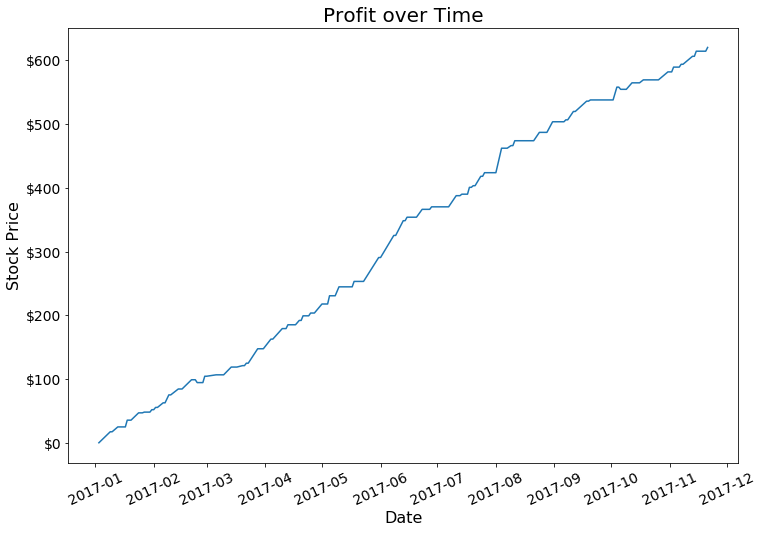

In [30]:
X, y = plot_profit(test_df, 'true_grow')

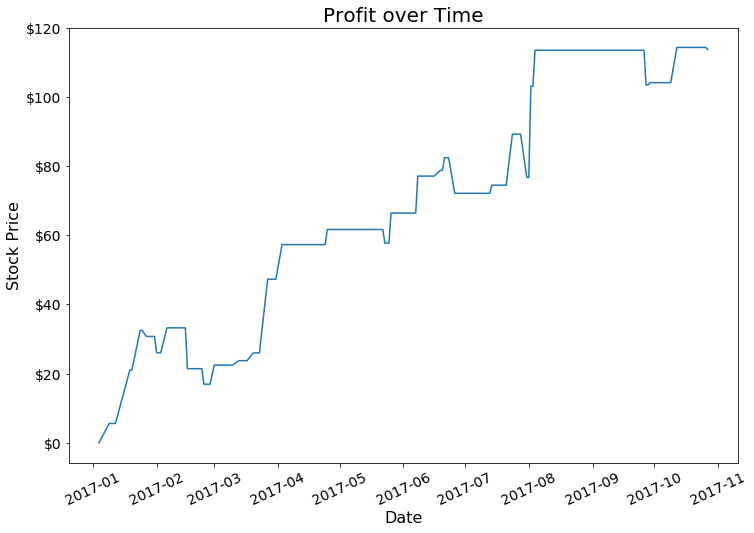

In [209]:
X, y = plot_profit(test_df, 'model_predict', early_stop=None)

In [161]:
importances = pd.DataFrame(xgb.feature_importances_)
importances['labels'] = X_train.columns
importances.sort_values(0, ascending=False)

,0,labels
305,0.097993,loss_gain
306,0.077922,spread
303,0.067296,forecast
1,0.066116,volume
2,0.050767,open
0,0.043684,close
4,0.034238,low
304,0.034238,next_day_open
3,0.029516,high
3138,0.016529,http _tesla_


In [ ]:
# gridsearch xgboost
start_time = t.time()

param_grid = {'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'gamma':[i/10.0 for i in range(0,5)],
              'n_estimators':[100,500,1000]
             }

dt = XGBClassifier()

grid = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc', verbose=1)

grid.fit(X_train, y_train)

best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}

best_dt = grid.best_estimator_

best_dt = best_dt.fit(X_train, y_train)

score = best_dt.score(X_test, y_test)

#print('Number of Models Run: ', len(n_estimators) * len(max_features) * len(min_samples_leaf) * 3)
print("{} Score: {:0.3}".format('Decision Tree Classifier', score.mean().round(3)), '\n')
print('Elapsed Time: {:0.3}'.format( t.time() - start_time), ' seconds', '\n')
print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


# OH CRAP

I need to rebuild the model EVERY DAY!

# Rebuild the Model from 2014 with proper train/test split

### Note on earliest NLP relevant info
1. elon earliest tweet 2013-03-23
2. tesla earliest tweet 2014-02-18
3. techmeme earliest story 2006-12-07

```stock.iloc[915]``` is 2014-02-18

In [53]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)

In [54]:
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)

In [55]:
# News sources binarize
mlb = MultiLabelBinarizer()

stock.news_sources = stock.news_sources.fillna('')
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)

### SARIMAX

The time series model requires yesterday's data to make a prediction.  We will always have that information, so the model will essentially need to be retrained daily to incorporate it.  (There may be a way to feed the existing model new information, but I am not sure.). It therefore makes sense to create the predictions before the train test split as each prediction should only be dependent on data from prior days.

In [56]:
model_df = stock.iloc[915:].copy()

In [57]:
mod = sm.tsa.statespace.SARIMAX(model_df.close, trend='n', order=(1,1,3), seasonal_order=(0,1,1,80))
results = mod.fit()
results.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  951
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 80)   Log Likelihood               -2907.625
Date:                            Sun, 24 Dec 2017   AIC                           5827.249
Time:                                    13:57:30   BIC                           5856.394
Sample:                                02-18-2014   HQIC                          5838.353
                                     - 11-22-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4877      0.792      0.616      0.538      -1.064       2.040
ma.L1         -0.4423      0.794     -0.557      0.577      -1.998       1.113
ma.L2          0.0137      0.055      0.251      0.802      -0.093       0.121
ma.L3         -0.0490      0.035     -1.386      0.166      -0.118       0.020
ma.S.L80      -0.9991      6.688     -0.149      0.881     -14.107      12.109
sigma2        37.3230    248.806      0.150      0.881    -450.328     524.974
===================================================================================
Ljung-Box (Q):                       22.88   Jarque-Bera (JB):               109.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.23
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
model_df['forecast'] = results.predict(dynamic=False)

In [59]:
model_df['target'] = model_df.close.shift(-1)
model_df['next_day_open'] = model_df.open.shift(-1) 
model_df['true_grow'] = model_df[['target', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis=1)

In [60]:
model_df.news_text = model_df.news_text.fillna('')
model_df.tesla_tweet = model_df.tesla_tweet.fillna('')
model_df.elon_tweet = model_df.elon_tweet.fillna('')

## WE REBUILD HERE

In [61]:
# We update this each time
real_test_df = model_df.iloc[725:-1].copy()
real_test_df['model_predict'] = np.NaN

### Train/test split

Split on ```model_df.iloc[725]``` as it is 2017-01-03

### Alright, here we go!

In [62]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

In [63]:
%%time
for num, i in enumerate(range(725, 950)):
    train_df = model_df.iloc[1:i]
    test_df = model_df.iloc[i:i+1]
    train_cvec_df, test_cvec_df = count_vect_our_dfs(train_df, test_df)
    train_df = train_cvec_df
    test_df = test_cvec_df
    X_train = train_df.drop(['target', 'true_grow'], 1)
    y_train = train_df.true_grow
    X_test = test_df.drop(['target', 'true_grow'], 1)
    xgb.fit(X_train, y_train)
    real_test_df.iat[num, -1] = xgb.predict(X_test)

In [64]:
real_test_df

,close,volume,open,high,low,news_text,tesla_tweet,elon_tweet,9to5Google,9to5Mac,...,iLounge,iMore,iPhone Hacks,iPhone in Canada Blog,lists.swift.org Mailing Lists,forecast,target,next_day_open,true_grow,model_predict
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,216.99,5901494.0,214.86,220.3300,210.9600,,,,0,0,...,0,0,0,0,0,214.345894,226.99,214.75,1,0.0
2017-01-04,226.99,11204560.0,214.75,228.0000,214.3100,,battery cell production begin at the gigafacto...,,0,0,...,0,0,0,0,0,216.666821,226.75,226.42,1,0.0
2017-01-05,226.75,5908927.0,226.42,227.4800,221.9500,,,hold-down firing of @spacex falcon 9 at vanden...,0,0,...,0,0,0,0,0,229.154491,229.01,226.93,1,1.0
2017-01-06,229.01,5524153.0,226.93,230.3100,225.4500,,,@pensasoda http t co 6ies7xbubs via @wired,0,0,...,0,0,0,0,0,225.668192,231.28,228.97,1,0.0
2017-01-09,231.28,3972716.0,228.97,231.9200,228.0000,,,,0,0,...,0,0,0,0,0,227.879001,229.87,232.00,0,0.0
2017-01-10,229.87,3658981.0,232.00,232.0000,226.8900,chris lattner join tesla a vp of autopilot sof...,welcome chris lattner http t co aaig6rhhdf,rt @teslamotors welcome chris lattner http t c...,0,1,...,0,1,1,1,1,232.658214,229.73,229.07,1,0.0
2017-01-11,229.73,3649910.0,229.07,229.9800,226.6800,,,@redletterdave the least cool character it s e...,0,0,...,0,0,0,0,0,231.287654,229.59,229.06,1,1.0
2017-01-12,229.59,3787547.0,229.06,230.7000,225.5800,,,@brandonr182 @sama have you tried steam engine...,0,0,...,0,0,0,0,0,229.386931,237.75,230.00,1,1.0
2017-01-13,237.75,6085610.0,230.00,237.8500,229.5900,,building the supercharger network for the futu...,rt @spacex tracking ground wind for tomorrow s...,0,0,...,0,0,0,0,0,227.790621,235.58,236.70,0,1.0


In [65]:
eval_sklearn_model(real_test_df.true_grow, real_test_df.model_predict)

True Negative:  82 | False Positive:  34
False Negative:  77 | True Positive:  32 

Sensitivity (TP/ TP + FN):  0.293577981651
Specificity (TN/ TN + FP):  0.706896551724 

Accuracy:  0.506666666667
Precision:  0.484848484848




In [66]:
print('Model Profit:')
profit_calculator(real_test_df, 'model_predict')
print('\nBest Case Profit:')
profit_calculator(real_test_df, 'true_grow')

Model Profit:
Own? True
Last Buying price: $ 316.77
Current price: $ 316.77
Cash? $ -315.95000000000016
Profit: $ 0.8199999999998226
Number of Transactins: 85
Cost of transactions: $ 425

Best Case Profit:
Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 620.0799999999999
Profit: $ 620.0799999999999
Number of Transactins: 118
Cost of transactions: $ 590


In [68]:
results = model_profit_evaluator(real_test_df, 'model_predict', 'next_day_open')

IndexError: single positional indexer is out-of-bounds

# ROLLING MEAN

In [70]:
model_df = stock.iloc[915:].copy()

In [71]:
rolmean = pd.rolling_mean(model_df.close, window=3)
model_df['rolmean'] = rolmean
mod = sm.tsa.statespace.SARIMAX(model_df.rolmean, trend='n', order=(1,1,0))
results = mod.fit()
results.summary()
model_df['forecast'] = results.predict()
model_df['target'] = model_df.rolmean.shift(-1)
model_df['next_day_open'] = model_df.open.shift(-1) 

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [72]:
#model_df['true_grow'] = model_df[['target', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 5 else 0 if x[0] - x[1] <= -5 else 2, axis=1)
model_df['true_grow'] = model_df[['target', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis=1)

In [73]:
model_df.news_text = model_df.news_text.fillna('')
model_df.tesla_tweet = model_df.tesla_tweet.fillna('')
model_df.elon_tweet = model_df.elon_tweet.fillna('')

### Train/test split

Split on ```model_df.iloc[725]``` as it is 2017-01-03

In [74]:
# Drop day one as no forecast can be made and last day as there is no "next_day_open"
train_df = model_df.iloc[1:725]
test_df = model_df.iloc[725:-1]

In [75]:
train_cvec_df, test_cvec_df = count_vect_our_dfs(train_df, test_df)
train_df = train_cvec_df
test_df = test_cvec_df

### Alright, here we go!

In [76]:
X_train = train_df.drop(['target', 'true_grow'], 1)
y_train = train_df.true_grow

In [77]:
X_test = test_df.drop(['target', 'true_grow'], 1)
y_test = test_df.true_grow

In [78]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

In [79]:
xgb.fit(X_train, y_train)
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  121 | False Positive:  2
False Negative:  86 | True Positive:  16 

Sensitivity (TP/ TP + FN):  0.156862745098
Specificity (TN/ TN + FP):  0.983739837398 

Accuracy:  0.608888888889
Precision:  0.888888888889
Roc-Auc:  0.652000637653




In [80]:
test_df['model_predict'] = test_predictions

In [81]:
profit_calculator(test_df, 'model_predict')

Own? False
Last Buying price: $ 352.95
Current price: $ 316.77
Cash? $ 44.97
Profit: $ 44.97
Number of Transactins: 26
Cost of transactions: $ 130


In [82]:
profit_calculator(test_df, 'true_grow')

Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 406.59
Profit: $ 406.59
Number of Transactins: 140
Cost of transactions: $ 700
